In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl
#import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense

# free data capture limits for some sources
# Get stock data from tiingo
# Ge treaury data from Quandl
import requests
nan=np.nan

In [2]:
DBGmode = 0
pd.set_option('display.max_rows', 10)
ticker = 'NVDA'
st_date = '2020-4-15'
#st_date = '2020-8-20'
en_date = '2020-9-11'

In [3]:
us10y_data = quandl.get("FRED/DGS10", start_date=st_date, end_date=en_date, api_key = 'tNjFxT5wYAG7nbemafxi')
us10y_data=us10y_data.reset_index()
us10y_data.rename(columns = {'Value':'US10Y'}, inplace = True) 

if DBGmode==1:
    us10y_data

In [4]:
for row in range(0,len(us10y_data)):
    us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
us10y_data=us10y_data.set_index('Date')

if DBGmode==1:
    us10y_data

<ipython-input-4-83275a74f87b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
/Users/prasannaob/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
def get_stock_data(stock_symbol, start_date, end_date):
    base_url = f'https://api.tiingo.com/tiingo/daily/{stock_symbol}/prices?'
    token = '59e2dfca5859e44a55ef766a8f81aab1ab8a80e8'
    payload = {
        'startDate': start_date,
        'endDate': end_date,
        'token': token
    }
    response = requests.get(base_url, params=payload)
    return response

In [6]:
response = get_stock_data(ticker, st_date, en_date)

if DBGmode == 1:
    print(response.url)
    print(response.json())

In [7]:
def parse_data(data_response):
    json_data = data_response.json()
    dates = []
    closes =[]
    opens = []
    highs = []
    lows = []
    vols = []
    for json_object in json_data:
        dates.append(json_object['date'])
        closes.append(json_object['close'])
        opens.append(json_object['open'])
        highs.append(json_object['high'])
        lows.append(json_object['low'])
        vols.append(json_object['volume'])
    return dates, closes, opens, highs, lows, vols

In [8]:
dates, closes, opens, highs, lows, vols = parse_data(response)

if DBGmode == 1:
    print(dates, closes)

In [9]:
datastock = pd.DataFrame(columns = ['Close'], index = dates)
dfindex = datastock.index
dfindex.name = 'Date'

In [10]:
datastock['Close']=closes

if DBGmode == 1:
    datastock

In [11]:
if DBGmode == 1:
    plt.plot(datastock['Close'], label=ticker+' Closes')
    plt.legend()
    plt.show()

In [12]:
print(len(datastock))
print(len(us10y_data))
data=pd.concat([datastock, us10y_data], axis=1, sort=False)

#fill US10Y NaN with previous value
data['US10Y'].fillna(method='ffill', inplace=True)

if DBGmode==1:
    #pd.set_option('display.max_rows', None)
    print(data)

105
104


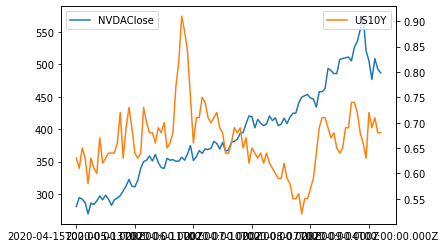

In [13]:
plt.figure()
data.Close.plot(label=ticker+'Close')
plt.legend()
data.US10Y.plot(secondary_y=True, label='US10Y')
plt.legend()
#plt.plot(data['Close'], label=ticker+' Closes')
#plt.plot(data['US10Y'], label='US10Y')
plt.show()

In [14]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

if DBGmode == 1:
    #scaled_data = data['Close']
    print(scaled_data)

In [15]:
train_length = int(len(scaled_data) * 0.7)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

if DBGmode == 1:
    print(len(scaled_data))
    print(train_length)
    print(test_length)
    train_data

In [16]:
def create_dataset(dataset, timestep=1):
    data_x, data_y = [], []
    #for i in range(len(dataset) - timestep - 1):
        #data_x.append(dataset[i:(i+timestep),0])
        #data_y.append(dataset[i+timestep,0])
    for i in range(len(dataset) - timestep):
        data_x.append(dataset[i:(i+timestep),0:2])
        data_y.append(dataset[i+timestep,0])
    return np.array(data_x), np.array(data_y)

In [17]:
timestep = 1
train_x, train_y = create_dataset(train_data, timestep)
test_x, test_y = create_dataset(test_data, timestep)

if DBGmode == 1:
    train_x

In [18]:
if DBGmode == 1:
    train_y

In [19]:
if DBGmode == 1:
    print(train_x.shape)
    print(test_x.shape)
    print(train_y.shape)
    print(test_y.shape)

In [20]:
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[2]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[2]))

if DBGmode == 1:
    train_x

In [21]:
#model = Sequential()
#model.add(LSTM(256, input_shape=(1,1)))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#print(model.summary())

model = Sequential()
model.add(LSTM(256, input_shape=(1,2)))
model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(6, input_dim=6, activation='relu'))
#model.add(Dense(6, activation='relu'))
#model.add(Dense(1, activation=None))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               265216    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 265,473
Trainable params: 265,473
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
model.fit(train_x, train_y, epochs=10, batch_size=1, verbose=1)
score = model.evaluate(train_x, train_y, verbose=0)
print('Keras model loss = ', score[0])
print('Keras model accuracy = ', score[1])

Epoch 1/10
72/72 [==============================] - 0s 1ms/step - loss: 0.0437 - accuracy: 0.0139
Epoch 2/10
72/72 [==============================] - 0s 1ms/step - loss: 0.0243 - accuracy: 0.0139
Epoch 3/10
72/72 [==============================] - 0s 1ms/step - loss: 0.0209 - accuracy: 0.0139  
Epoch 4/10
72/72 [==============================] - 0s 1ms/step - loss: 0.0179 - accuracy: 0.0139  
Epoch 5/10
72/72 [==============================] - 0s 1ms/step - loss: 0.0151 - accuracy: 0.0139
Epoch 6/10
72/72 [==============================] - 0s 1ms/step - loss: 0.0119 - accuracy: 0.0139
Epoch 7/10
72/72 [==============================] - 0s 1ms/step - loss: 0.0092 - accuracy: 0.0139
Epoch 8/10
72/72 [==============================] - 0s 1ms/step - loss: 0.0063 - accuracy: 0.0139
Epoch 9/10
72/72 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 0.0139  
Epoch 10/10
72/72 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.0139  
Keras model

In [23]:
train_predictions = model.predict(train_x)
test_predictions = model.predict(test_x)

if DBGmode == 1:
    print(train_predictions)

In [24]:
# create empty table with 2 fields
train_predictions_like = np.zeros(shape=(len(train_predictions), 2) )
# put the predicted values in the right field
train_predictions_like[:,0] = train_predictions[:,0]
# inverse transform and then select the right field
train_predictions = scaler.inverse_transform(train_predictions_like)[:,0]

# create empty table with 2 fields
test_predictions_like = np.zeros(shape=(len(test_predictions), 2) )
# put the predicted values in the right field
test_predictions_like[:,0] = test_predictions[:,0]
# inverse transform and then select the right field
test_predictions = scaler.inverse_transform(test_predictions_like)[:,0]


In [25]:
#train_predictions = scaler.inverse_transform(train_predictions)
#train_y = scaler.inverse_transform([train_y])

#test_predictions = scaler.inverse_transform(test_predictions)
#test_y = scaler.inverse_transform([test_y])

if DBGmode == 1:
    print(train_predictions)
    print(test_predictions)

In [26]:
#train_predict_plot = np.empty_like(scaled_data[:,0])
train_predict_plot = scaled_data[:,0]
train_predict_plot[:] = np.nan
train_predict_plot[1:len(train_predictions)+1] = train_predictions

In [27]:
test_predict_plot = np.empty_like(scaled_data[:,0])
test_predict_plot[:] = np.nan
test_predict_plot[
    len(train_predictions)+2:len(scaled_data)] = test_predictions

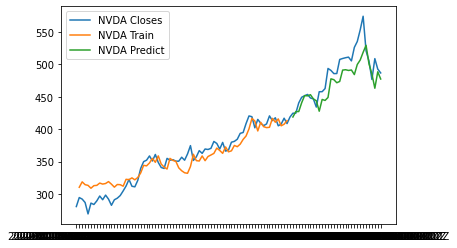

In [28]:
plt.plot(data.Close, label = ticker+' Closes')
plt.plot(train_predict_plot, label = ticker+' Train')
plt.plot(test_predict_plot, label = ticker+' Predict')
plt.legend()
plt.show()

In [29]:
print(len(data['Close']))
print(len(train_predictions))
print(len(test_predictions))

105
72
31


In [30]:
data['AITrain'] = train_predict_plot
data['AITest'] = test_predict_plot
data.tail()

,Close,US10Y,AITrain,AITest
2020-09-04T00:00:00.000Z,504.90,0.72,NaN,500.636005
2020-09-08T00:00:00.000Z,476.52,0.69,NaN,484.941910
2020-09-09T00:00:00.000Z,508.60,0.71,NaN,463.019577
2020-09-10T00:00:00.000Z,492.47,0.68,NaN,488.335867
2020-09-11T00:00:00.000Z,486.58,0.68,NaN,477.245076


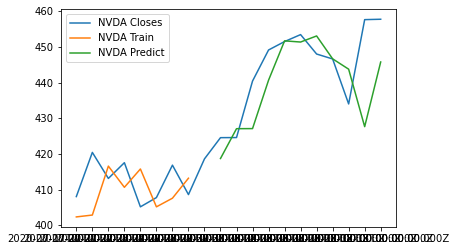

In [31]:
plt.plot(data.Close[-40:-20], label = ticker+' Closes')
plt.plot(train_predict_plot[-40:-20], label = ticker+' Train')
plt.plot(test_predict_plot[-40:-20], label = ticker+' Predict')
plt.legend()
plt.show()

In [32]:
#data.to_csv(ticker+'_predict.csv')